In [1]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

In [82]:
class ReservoirComputer:
    def __init__(self, dim_system, dim_reservoir, rho, sigma, density):
        self.dim_system = dim_system
        self.dim_reservoir = dim_reservoir
        self.r_state = np.zeros(dim_reservoir)
        #self.A = generate_adjacency_matrix(dim_reservoir, rho, sigma)
        self.A = 0
        self.W_in = 2 * sigma * (np.random.rand(dim_reservoir, dim_system) - .5)
        self.W_out = np.zeros((dim_system, dim_reservoir))
    
    def advance_r_state(self, u):
        self.r_state = sigmoid(np.dot(self.A, self.r_state) + np.dot(self.W_in, u))
        return self.r_state
    
    def v(self):
        return np.dot(self.W_out, self.r_state)
    
    def train(self, trajectory):
        #trajectory has shape (n, dim_system), n is the number of timesteps
        R = np.zeros((self.dim_reservoir, trajectory.shape[0]))
        for i in range(trajectory.shape[0]):
            R[:, i] = self.r_state
            u = trajectory[i]
            self.advance_r_state(u)
        self.W_out = linear_regression(R, trajectory)
    
    def predict(self, steps):
        prediction = np.zeros((steps, self.dim_system))
        for i in range(steps):
            v = self.v()
            prediction[i] = v
            self.advance_r_state(prediction[i])
        return prediction

In [83]:
def sigmoid(x):
    return np.where(x >= 0, 
                    1 / (1 + np.exp(-x)), 
                    np.exp(x) / (1 + np.exp(x)))

In [84]:
def generate_adjacency_matrix(dim_reservoir, rho, sigma):
    
    graph = nx.gnp_random_graph(dim_reservoir, sigma)
    graph = nx.to_numpy_array(graph)
    
    # Ensure random_array is of the same shape as the graph adjacency matrix.
    random_array = 2 * (np.random.rand(dim_reservoir, dim_reservoir) - 0.5)
    
    # Multiply graph adjacency matrix with random values.
    rescaled = graph * random_array
    return scale_matrix(rescaled, rho)
    

In [85]:
def scale_matrix(A, rho):
    eigenvalues, _ = np.linalg.eig(A)
    max_eigenvalue = np.amax(eigenvalues)
    A = A/np.absolute(max_eigenvalue) * rho
    return A

In [86]:
def linear_regression(R, trajectory, beta=0.0001):  
    Rt = np.transpose(R)
    inverse_part = np.linalg.inv(np.dot(R, Rt) + beta * np.identity(R.shape[0]))
    return np.dot(np.dot(trajectory.T, Rt), inverse_part)


In [87]:
def lorenz(t, x, y, z, sigma, rho, beta):
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x*y - beta*z
    return dxdt, dydt, dzdt

In [88]:
def rk4(t, x, y, z, dt, sigma, rho, beta):
    f1x, f1y, f1z = lorenz(t, x, y, z, sigma, rho, beta)
    
    k1x = dt * f1x
    k1y = dt * f1y
    k1z = dt * f1z
    
    f2x, f2y, f2z = lorenz(t + 0.5*dt, x + 0.5*k1x, y + 0.5*k1y, z + 0.5*k1z, sigma, rho, beta)

    k2x = dt * f2x
    k2y = dt * f2y
    k2z = dt * f2z

    f3x, f3y, f3z = lorenz(t + 0.5*dt, x + 0.5*k2x, y + 0.5*k2y, z + 0.5*k2z, sigma, rho, beta)

    k3x = dt * f3x
    k3y = dt * f3y
    k3z = dt * f3z

    f4x, f4y, f4z = lorenz(t + dt, x + k3x, y + k3y, z + k3z, sigma, rho, beta)

    k4x = dt * f4x
    k4y = dt * f4y
    k4z = dt * f4z

    x += (k1x + 2*k2x + 2*k3x + k4x) / 6.0
    y += (k1y + 2*k2y + 2*k3y + k4y) / 6.0
    z += (k1z + 2*k2z + 2*k3z + k4z) / 6.0

    return x, y, z

In [89]:
#initial conditions
x0, y0, z0 = 1, 1, 1
sigma, rho, beta = 10, 28, 8/3
t, dt = 0, 0.01
#integration loop
x_list = []
y_list = []
z_list = []
for i in range(20000):
    x, y, z = rk4(t, x0, y0, z0, dt, sigma, rho, beta)
    x_list.append(x)
    y_list.append(y)
    z_list.append(z)
    x0, y0, z0 = x, y, z 
    t += dt

In [90]:
data = []
for i in range(len(x_list)):
    u_i = [x_list[i], y_list[i], z_list[i]]
    data.append(u_i)

In [91]:
data_length = len(data) 
training_percentage = .7
training_data = np.array(data[:int(data_length*training_percentage)])
valid_data = np.array(data[int(data_length*training_percentage):])

In [92]:
dim_reservoir = 300
model = ReservoirComputer(3, dim_reservoir, 1.1, 0.1, 0.05)
model.train(training_data)
predicted_data = model.predict(len(valid_data))

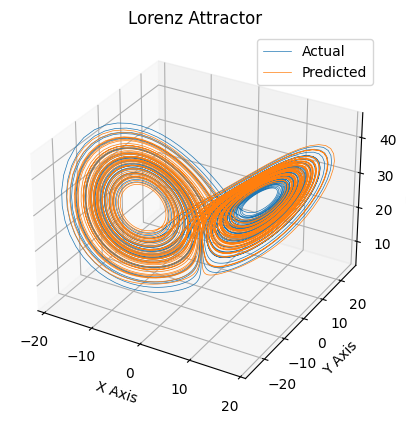

In [113]:
# Plot
ax = plt.figure().add_subplot(projection='3d')

x_data = valid_data[:, 0]
y_data = valid_data[:, 1]
z_data = valid_data[:, 2]

x_pred = predicted_data[:, 0]
y_pred = predicted_data[:, 1]
z_pred = predicted_data[:, 2]

ax.plot(x_data, y_data, z_data, lw=0.5, label="Actual")
ax.plot(x_pred, y_pred, z_pred, lw=0.5, label="Predicted")
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.legend()
ax.set_title("Lorenz Attractor")

plt.show()


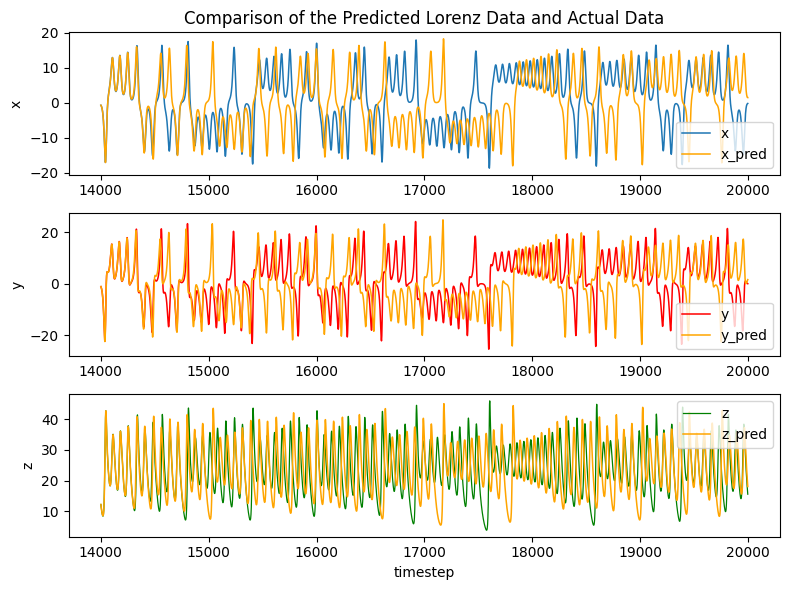

In [110]:
fig, axs = plt.subplots(3, 1, figsize=(8, 6))  

# Plot data on each subplot
timesteps = [*range(training_data.shape[0], data_length, 1)]

axs[0].plot(timesteps, x_data, label="x", lw=1.1)
axs[0].plot(timesteps, x_pred, label="x_pred", color='orange', lw=1.1)  # I changed the label to 'x_pred' for clarity
axs[0].set_ylabel("x")
axs[0].set_title("Comparison of the Predicted Lorenz Data and Actual Data")
axs[0].legend()

axs[1].plot(timesteps, y_data, label="y", color='r', lw=1.1)
axs[1].plot(timesteps, y_pred, label="y_pred", color='orange', lw=1.1)  # I changed the label to 'y_pred' for clarity
axs[1].set_ylabel("y")
axs[1].legend()

axs[2].plot(timesteps, z_data, label="z", color='g', lw=.9)
axs[2].plot(timesteps, z_pred, label="z_pred", color='orange', lw=1.1)  # I changed the label to 'z_pred' for clarity
axs[2].set_ylabel("z")
axs[2].set_xlabel("timestep")
axs[2].legend()

fig.tight_layout()

plt.show()

(a) Training System:


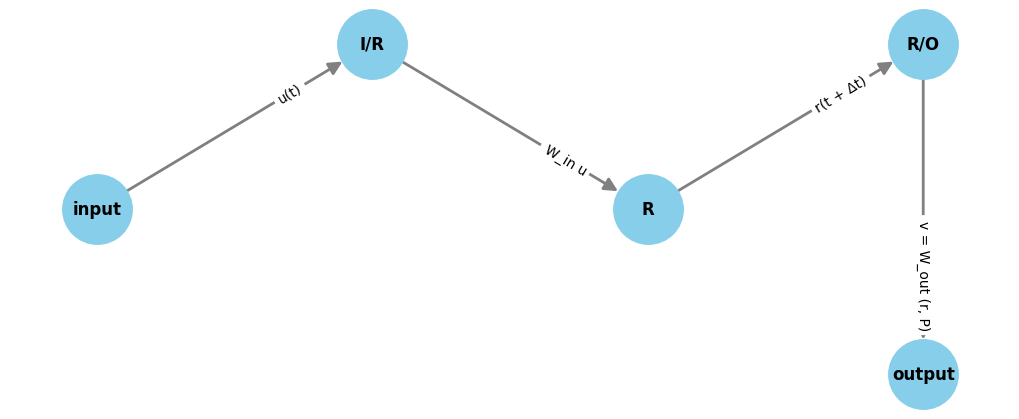

(b) Prediction System:


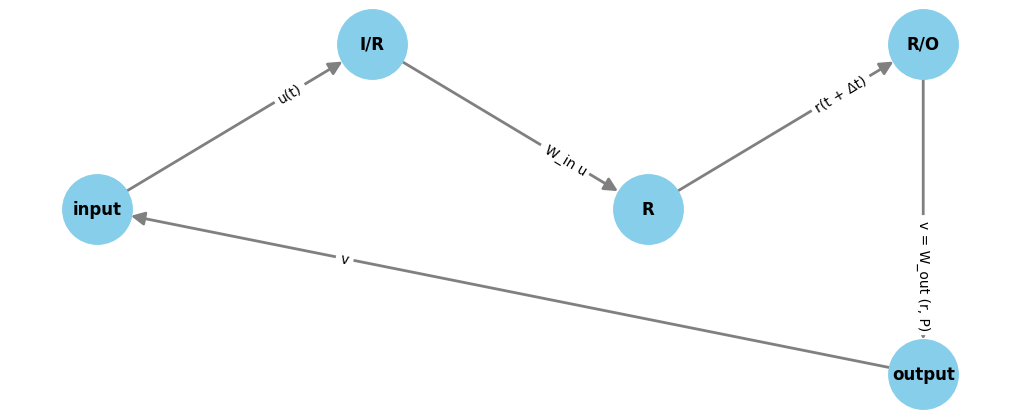

In [12]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_system(feedback=False):
    # Create a directed graph
    G = nx.DiGraph()

    nodes = {
        'input': (0, 1), 
        'I/R': (1, 2), 
        'R': (2, 1), 
        'R/O': (3, 2), 
        'output': (3, 0)  # Move the 'output' node slightly to the left
    }

    edges = [
        ('input', 'I/R', 'u(t)'),
        ('I/R', 'R', 'W_in u'),
        ('R', 'R/O', 'r(t + Δt)'),
        ('R/O', 'output', 'v = W_out (r, P)')
    ]

    if feedback:
        edges.append(('output', 'input', 'v'))

    G.add_nodes_from(nodes)
    pos = nodes
    labels = {}
    
    for start, end, label in edges:
        G.add_edge(start, end)
        labels[(start, end)] = label

    plt.figure(figsize=(10, 4))
    nx.draw(G, pos, with_labels=True, node_size=2500, node_color="skyblue", font_size=12, font_weight="bold", width=2, edge_color="gray", arrowsize=20)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=10, label_pos=0.3)
    
    plt.axis('off')
    plt.savefig('reservoir_computer.png')
    plt.show()

# Plot training system (a)
print("(a) Training System:")
plot_system()

# Plot prediction system (b)
print("(b) Prediction System:")
plot_system(feedback=True)

